# XGBoost to predict the predicted shift in mRS discharge disability due to use of thrombolysis
#### Using 7 features to train a XGBoost regression model 
(code based on notebook 050)

Use the same input features as those used in the disability discharge outcome model, predict the predicted mRS shift due to thrombolysis treatment. 
In next notebook (220) fit SHAP values to the mRS shift model.

### Plain English summary

Assess the performance of a model trained on the selected 7 features, as informed from the feature selection process. Use the first k-fold split.

7 features:
1. prior_disability
1. stroke_severity
1. stroke_team
1. age
1. onset_to_thrombolysis_time
1. any_afib_diagnosis
1. precise_onset_known

### Model and data
Model: XGBoost classifier.\
Patient population: Those get IVT in the dataset\
Feature data: 7 selected features\
Target feature: Predicted mRS shift in discharge disability due to treatment (for those patients that got thrombolysis in the dataset)\
Data: The first kfold\

### Aims
What's the performance of a model using the 7 selected features?

##### Section 1: Accuracy of model (and consistency across k-folds)
Look at accuracy in terms of:
1. Accuracy (i. % correct, ii. % within one correct)
1. Confusion matrix
1. ROCAUC
##### Section 2: Calibration and assessment of accuracy when model has high confidence
##### Section 3: Reliability

### Observations


## Import libraries

In [20]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBRegressor#Classifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

import pickle
import shap

from os.path import exists

import math

import importlib

from sklearn import metrics
from sklearn.linear_model import LinearRegression
# Import local package
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall);

# Need for cm subplots?
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LogNorm
#from matplotlib.ticker import MultipleLocator

import time


# sklearn for pre-processing
from sklearn.model_selection import StratifiedKFold

Report the time duration to run notebook

In [21]:
start_time = time.time()

Set to use only the first kfold

In [22]:
k = 0

Select the features for the model

In [23]:
selected_features_outcome = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
target_feature = 'predicted_mrs_shift_due_to_thrombolysis'
n_features = len(selected_features_outcome)
selected_features = selected_features_outcome + [target_feature]

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [24]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    data_save_path: str = './saved_data'
    model_save_path: str = './saved_models'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_7_features_1fold_mrs_shift'
    notebook: str = '220'

paths = Paths()

Create output folders if needed

In [25]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

Import data

In [26]:
# Read in training set & store
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)

For this analysis, as we are predicting the mRS shift from a patient having thrombolysis, let's only use patients that use thrombolysis, and train a model on their mRS shift due to having treatment (don't give treatment to patients that didn't get treatment in the dataset, those patients could have characteristics that are not in the thrombolysable dataset).

In [27]:
train = train[train["onset_to_thrombolysis_time"] > -100]
test = test[test["onset_to_thrombolysis_time"] > -100]

In [28]:
train_stroke_team = train["stroke_team"]
test_stroke_team = test["stroke_team"]

Calculate the median scan to needle time for each hosptial

In [29]:
all_data = pd.concat([train, test])

# median scan to treatment for the treated patients (per hosptial)
mask_treatment = all_data["onset_to_thrombolysis_time"] > -100
median_scan_to_needle_time = (
    all_data[mask_treatment].groupby(["stroke_team"])["scan_to_thrombolysis_time"].median())

median_scan_to_needle_time

stroke_team
Addenbrooke's Hospital          20.0
Basildon University Hospital    34.0
Blackpool Victoria Hospital     37.0
Bradford and Airedale SU        47.0
Bronglais Hospital              39.5
                                ... 
Worthing Hospital               38.0
Wycombe General Hospital        29.0
Yeovil District Hospital        37.0
York Hospital                   29.0
Ysbyty Gwynedd                  44.0
Name: scan_to_thrombolysis_time, Length: 118, dtype: float64

In [30]:
# For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
train_onset_to_scan_time = train["onset_to_arrival_time"] + train["arrival_to_scan_time"]
test_onset_to_scan_time = test["onset_to_arrival_time"] + test["arrival_to_scan_time"]

Select the features for this model

In [31]:
train = train[selected_features_outcome]
test = test[selected_features_outcome]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [32]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [33]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [34]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [35]:
features_ohe = list(train)
n_features = len(features_ohe)

In [36]:
print(f"There are {len(selected_features_outcome)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 7 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


In [37]:
print(f'{train["onset_to_thrombolysis_time"].min()} to {train["onset_to_thrombolysis_time"].max()}')

7.0 to 720.0


In [38]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                '210_xgb_all_data_multiclass_outcome.p')

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model_outcome = pickle.load(filehandler)
    mrs_classes = model_outcome.classes_
else:
    # Print warning
    print("Run notebook 210 that trains the multiclass outcome model")

In [39]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(weighted_mrs)

In [40]:
def calculate_target_feature(data, model_outcome,median_scan_to_needle_time, 
                             onset_to_scan_time, stroke_team):
    # Identify patients not recieve treatment in the dataset
    mask_not_treated = data["onset_to_thrombolysis_time"] == -100

    # Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
    # for those patients that recieve treatment in the dataset
    onset_to_thrombolysis_time_all_treated = data["onset_to_thrombolysis_time"].copy(deep=True)

    # For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
    #onset_to_scan_time = data["onset_to_arrival_time"] + data["arrival_to_scan_time"]

    #median_scan_to_needle_time = calc_median_scan_to_needle_time(data)
    onset_to_thrombolysis_time_all_treated[mask_not_treated] = (
        onset_to_scan_time[mask_not_treated] + 
        median_scan_to_needle_time[stroke_team[mask_not_treated]])

    # get mrs if treated
    data["onset_to_thrombolysis_time"] = onset_to_thrombolysis_time_all_treated
    y_probs = model_outcome.predict_proba(data)
    weighted_mrs_if_get_ivt = calculate_population_outcome(y_probs, mrs_classes)

    # get mrs if not treated
    data["onset_to_thrombolysis_time"] = -100
    y_probs = model_outcome.predict_proba(data)
    weighted_mrs_if_not_get_ivt = calculate_population_outcome(y_probs, mrs_classes)

    # Calculate mrs shift
    mrs_shift_due_to_thrombolysis = weighted_mrs_if_get_ivt - weighted_mrs_if_not_get_ivt

    return(mrs_shift_due_to_thrombolysis)

In [41]:
print(f'{train["onset_to_thrombolysis_time"].min()} to {train["onset_to_thrombolysis_time"].max()}')

7.0 to 720.0


In [42]:
train[target_feature] = calculate_target_feature(train.copy(deep=True), model_outcome, 
                                                 median_scan_to_needle_time, 
                                                 train_onset_to_scan_time, 
                                                 train_stroke_team)
test[target_feature] = calculate_target_feature(test.copy(deep=True), model_outcome, 
                                                median_scan_to_needle_time, 
                                                test_onset_to_scan_time, 
                                                test_stroke_team)

In [43]:
print(f'{train["onset_to_thrombolysis_time"].min()} to {train["onset_to_thrombolysis_time"].max()}')

7.0 to 720.0


Save datafiles to use in notebook 221

In [44]:
filename = os.path.join(paths.data_read_path, 
                        (paths.notebook + '_train_' + str(k) + '_mrs_shift.csv'))
train.to_csv(filename)

filename = os.path.join(paths.data_read_path, 
                        (paths.notebook + '_test_' + str(k) + '_mrs_shift.csv'))
test.to_csv(filename)

## Train XGBoost model

Train model using the first kfold, on the seven selected features to predict the predicted shift in disability of each patient at discharge due to thrombolysis.

Create function to return X and y data for train and test sets

In [45]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to get xgboost model (print error if does not exist)

In [46]:
def fit_xgboost_model(filename, X, y):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train anew model.

    filename [string]: where xgboost model is saved
    X_train [dataframe]: feature values
    y_train [dataframe]: target feature
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBRegressor(verbosity = 0, seed=42, learning_rate=0.5)
        model.fit(X, y)

        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
            
    return(model)

In [47]:
# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train,
                                                  test,
                                                  target_feature)

# Model filename
filename = os.path.join(paths.model_save_path, 
                (paths.notebook + '_' + paths.model_text + '.p'))

model = fit_xgboost_model(filename, X_train, y_train)

# Get and store prediction
y_pred = model.predict(X_test)

# Calculate accuracy
# evaluate predictions
mse = mean_squared_error(y_pred, y_test)
print("mean_squared_error: %.2f%%" % (mse))

mean_squared_error: 0.04%


#### Accuracy: Scatter plot

In [48]:
def fit_logstic_regression(x, y):
    # Get r-square of predicted thrombolysis rate.
    slr = LinearRegression()
    slr.fit(x, y)
    y_pred = slr.predict(x)
    r_square = metrics.r2_score(y, y_pred)
    return(slr, r_square)

Text(0, 0.5, 'Predicted weighted mRS shift')

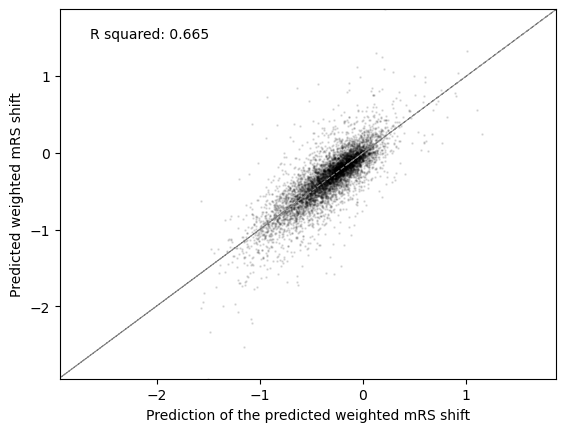

In [49]:
ax = plt.scatter(y_test, y_pred, s=0.8, alpha=0.1, c='k', marker='o')
axis_min = min(np.minimum(y_pred, y_test))
axis_max = max(np.maximum(y_pred, y_test))
# The full dataset
(slr, r_square) = fit_logstic_regression(y_pred.reshape((-1, 1)), y_test)

ax = plt.plot(y_test, slr.predict(np.array(y_test).reshape((-1, 1))), color = 'grey', linewidth=0.8, linestyle="--")
text = f'R squared: {r_square:.3f}'
ax = plt.text(axis_min*0.9, axis_max*0.8, text, 
            bbox=dict(facecolor='white', edgecolor='white'))
ax = plt.xlim(axis_min, axis_max)
ax = plt.ylim(axis_min, axis_max)
#ax = plt.plot([-3,2],[-3,2], c='grey',linewidth=1, linestyle ='--')
plt.xlabel("Predicted weighted mRS shift")
plt.ylabel("Prediction of the predicted weighted mRS shift")


Removed the sections on calibration and reliability, as this code is to analyse classification models, and not regression models.

To do: Add any additional accuracy analysis?